In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/cl2292/project/')
import xgboost as xgb
import shap
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.stats import zscore, binned_statistic
from scipy.ndimage import gaussian_filter1d

from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer
from hyperopt import tpe, Trials, fmin, hp, STATUS_OK



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

x = pd.read_csv('/home/cl2292/project/SCA1_snRNAseq/Mouse/results/top50_dyngenes_v2(all_ctype).csv', index_col=0)
ntimebins=20
cm = plt.get_cmap('magma')
timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

In [6]:
diffs = pd.DataFrame()
for i in ['GC','UBC','PC','MLI1','MLI2','GoC','AS','BG','OPC','OL','MG','PER','END','DCN']:
    if i == 'DCN':
        x_diff = x.loc[x['ctype']==i, [str(ii) for ii in range(1, ntimebins+1)]+['index']].set_index('index')
        x_diff_melted = x_diff.T.reset_index().rename(columns={'index':'time'})
        x_diff_melted['time'] = x_diff_melted['time'].astype(int)

        x_diff_melted = x_diff_melted.melt(id_vars='time', var_name='topGenes', value_name='mut-wt')

        plotting = False

        z = x_diff.abs().mean(axis=0).reset_index().rename(columns={'index':'time'})
        z['time'] = z['time'].astype(int)
        z = z.rename(columns={0:'ave_mut-wt'})
        z['ave_mut-wt'][8] = 0.830641

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )

        if plotting:
            fig, ax = plt.subplots(1,1, figsize=(4,3))
            sns.barplot(x='time', y='ave_mut-wt', data=z, color='gray', ax=ax)
            ax.plot(z['time']-1, yprime, color='gray')
            ax.fill_between(z['time']-1, 0, yprime, color='gray', alpha=0.2)

        dt = pd.DataFrame({'time':z['time'] - 1, 'ave_mut-wt':yprime})
        dt['ctype'] = i

        diffs = diffs.append(dt, ignore_index=True)
    else:
        x_diff = x.loc[x['ctype']==i, [str(ii) for ii in range(1, ntimebins+1)]+['index']].set_index('index')

        x_diff_melted = x_diff.T.reset_index().rename(columns={'index':'time'})
        x_diff_melted['time'] = x_diff_melted['time'].astype(int)

        x_diff_melted = x_diff_melted.melt(id_vars='time', var_name='topGenes', value_name='mut-wt')

        plotting = False

        z = x_diff.abs().mean(axis=0).reset_index().rename(columns={'index':'time'})
        z['time'] = z['time'].astype(int)
        z = z.rename(columns={0:'ave_mut-wt'})

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )

        if plotting:
            fig, ax = plt.subplots(1,1, figsize=(4,3))
            sns.barplot(x='time', y='ave_mut-wt', data=z, color='gray', ax=ax)
            ax.plot(z['time']-1, yprime, color='gray')
            ax.fill_between(z['time']-1, 0, yprime, color='gray', alpha=0.2)

        dt = pd.DataFrame({'time':z['time'] - 1, 'ave_mut-wt':yprime})
        dt['ctype'] = i

        diffs = diffs.append(dt, ignore_index=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# aesthetics 

cmap_ctype={'GC': '#FAC18A',
            'DCN': '#AAABAB',
            'UBC': '#BA61BA',
            'PC': '#EE5264',
            'MLI1': '#F9EBAE',
            'MLI2': '#88BB92',
            'GoC': '#46A928',
            'AS': '#F9AEAE',
            'BG': '#AEB7F9',
            'OPC': '#F1815F',
            'OL': '#75A3B7',
            'MG': '#AC5861',
            'PER': '#2D284B',
            'END': '#1C67EE'}

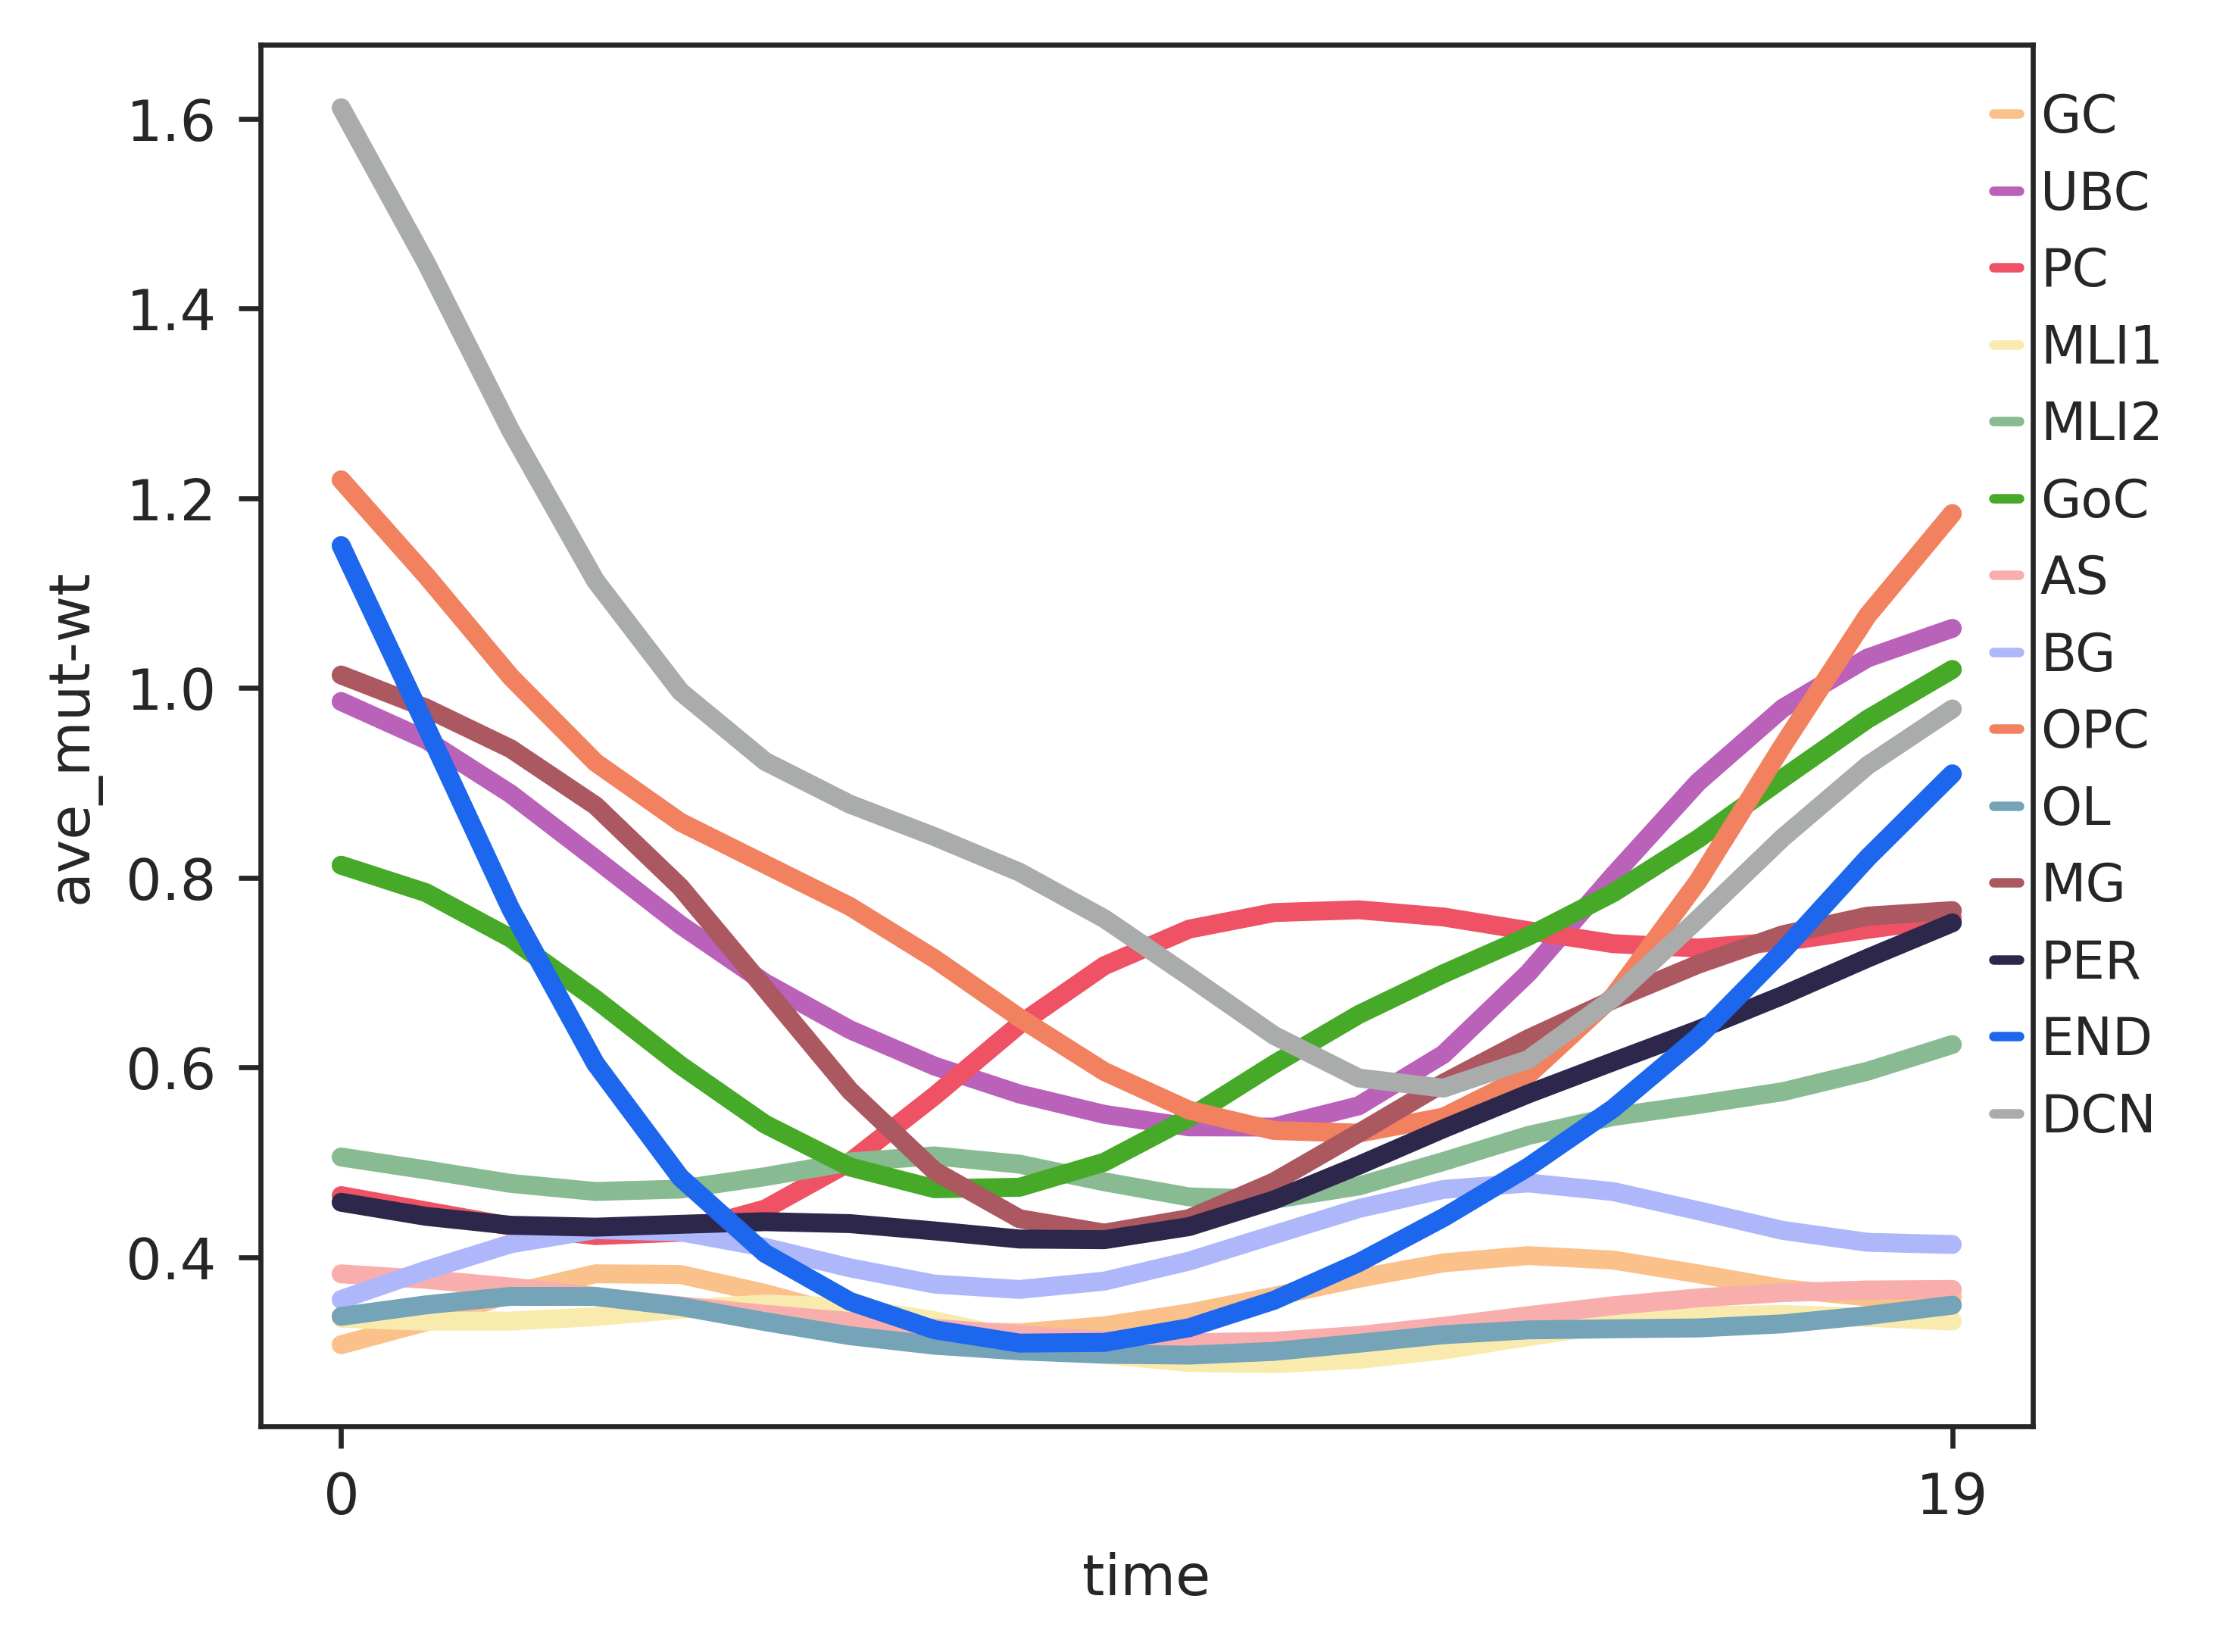

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.lineplot(x='time', y='ave_mut-wt', hue='ctype', size=None, 
                 style=None, data=diffs, palette=cmap_ctype, hue_order=None, 
                 hue_norm=None, sizes=None, size_order=None, size_norm=None, 
                 dashes=True, markers=None, style_order=None, 
                 units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, 
                 err_style='band', err_kws=None, legend='brief', ax=ax, lw=3)
ax.legend(bbox_to_anchor=(1.1,1)).set_title('')
ax.set_xticks([0,19])
fig.savefig(os.path.join(pfp, '220902_dyn_ctype.pdf'), bbox_inches='tight')

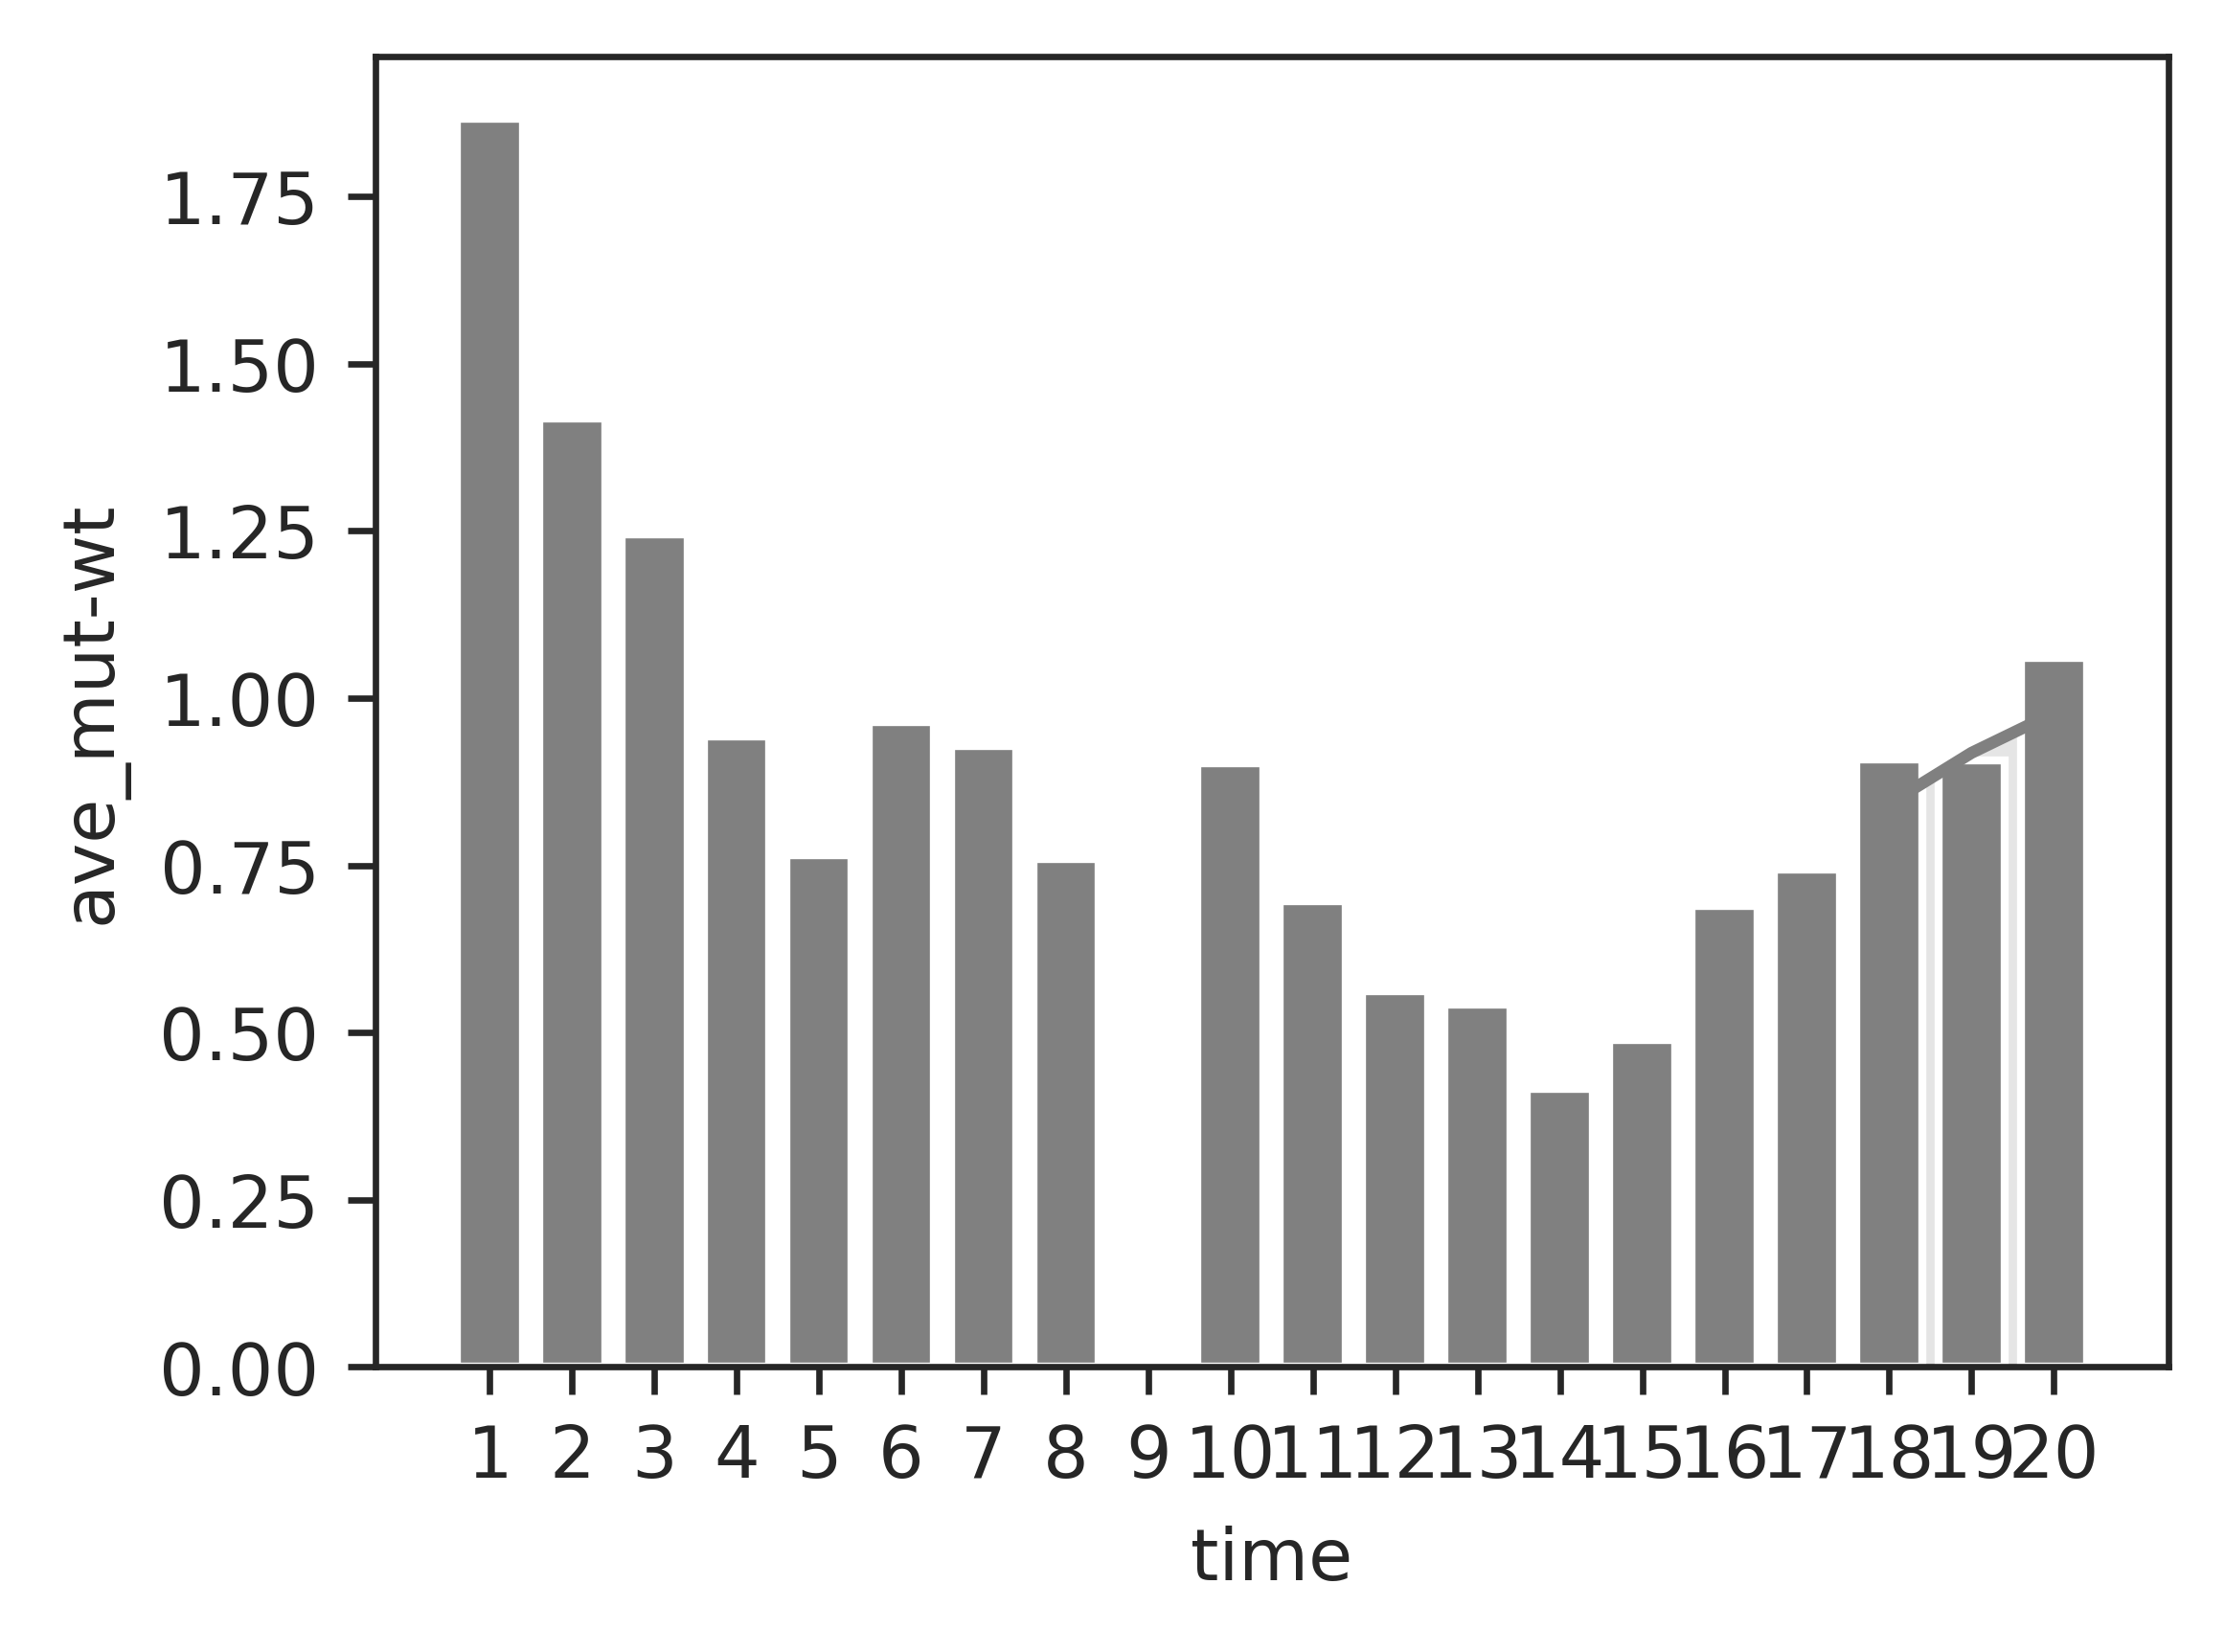

In [58]:
diffs = pd.DataFrame()

for i in ['DCN']:
    x_diff = x.loc[x['ctype']==i, [str(ii) for ii in range(1, ntimebins+1)]+['index']].set_index('index')

    x_diff_melted = x_diff.T.reset_index().rename(columns={'index':'time'})
    x_diff_melted['time'] = x_diff_melted['time'].astype(int)

    x_diff_melted = x_diff_melted.melt(id_vars='time', var_name='topGenes', value_name='mut-wt')
    
    plotting = True

    z = x_diff.abs().mean(axis=0).reset_index().rename(columns={'index':'time'})
    z['time'] = z['time'].astype(int)
    z = z.rename(columns={0:'ave_mut-wt'})
    

    # smoothed
    yprime = gaussian_filter1d(
        z['ave_mut-wt'],
        2,
        axis=-1,
        order=0,
        output=None,
        mode='nearest',
        cval=0.0,
        truncate=4.0,
    )
    
    if plotting:
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        sns.barplot(x='time', y='ave_mut-wt', data=z, color='gray', ax=ax)
        ax.plot(z['time']-1, yprime, color='gray')
        ax.fill_between(z['time']-1, 0, yprime, color='gray', alpha=0.2)

    dt = pd.DataFrame({'time':z['time'] - 1, 'ave_mut-wt':yprime})
    dt['ctype'] = i

    diffs = diffs.append(dt, ignore_index=True)

In [84]:
diffs.drop(labels = []'DCN', axis=0, inplace = False)

TypeError: drop() got an unexpected keyword argument 'lable'

In [68]:
yprime = gaussian_filter1d(
    dcn['ave_mut-wt'],
    2,
    axis=-1,
    order=0,
    output=None,
    mode='nearest',
    cval=0.0,
    truncate=4.0,
)
dt = pd.DataFrame({'time':dcn['time'] - 1, 'ave_mut-wt':yprime})
dt['ctype'] = 'DCN'
dt

,time,ave_mut-wt,ctype
0,0,1.611590,DCN
1,1,1.448524,DCN
2,2,1.271188,DCN
3,3,1.112962,DCN
4,4,0.996240,DCN
5,5,0.922493,DCN
6,6,0.877376,DCN
7,7,0.843080,DCN
8,8,0.805671,DCN
9,9,0.756686,DCN


In [78]:
dt

,time,ave_mut-wt,ctype
0,0,1.611590,DCN
1,1,1.448524,DCN
2,2,1.271188,DCN
3,3,1.112962,DCN
4,4,0.996240,DCN
5,5,0.922493,DCN
6,6,0.877376,DCN
7,7,0.843080,DCN
8,8,0.805671,DCN
9,9,0.756686,DCN


In [80]:
diff2 = diffs[diffs['ctype']=='DCN']

In [81]:
diff2['ave_mut-wt'] = dt['ave_mut-wt']
diff2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,time,ave_mut-wt,ctype
220,0,NaN,DCN
221,1,NaN,DCN
222,2,NaN,DCN
223,3,NaN,DCN
224,4,NaN,DCN
225,5,NaN,DCN
226,6,NaN,DCN
227,7,NaN,DCN
228,8,NaN,DCN
229,9,NaN,DCN


In [44]:
diffs['ave_mut-wt'][228] = 0.830641


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
dcn

,time,ave_mut-wt,ctype
220,0,NaN,DCN
221,1,NaN,DCN
222,2,NaN,DCN
223,3,NaN,DCN
224,4,NaN,DCN
225,5,NaN,DCN
226,6,NaN,DCN
227,7,NaN,DCN
228,8,NaN,DCN
229,9,NaN,DCN


In [62]:
z['ave_mut-wt'][8] = 0.830641
dcn = z


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


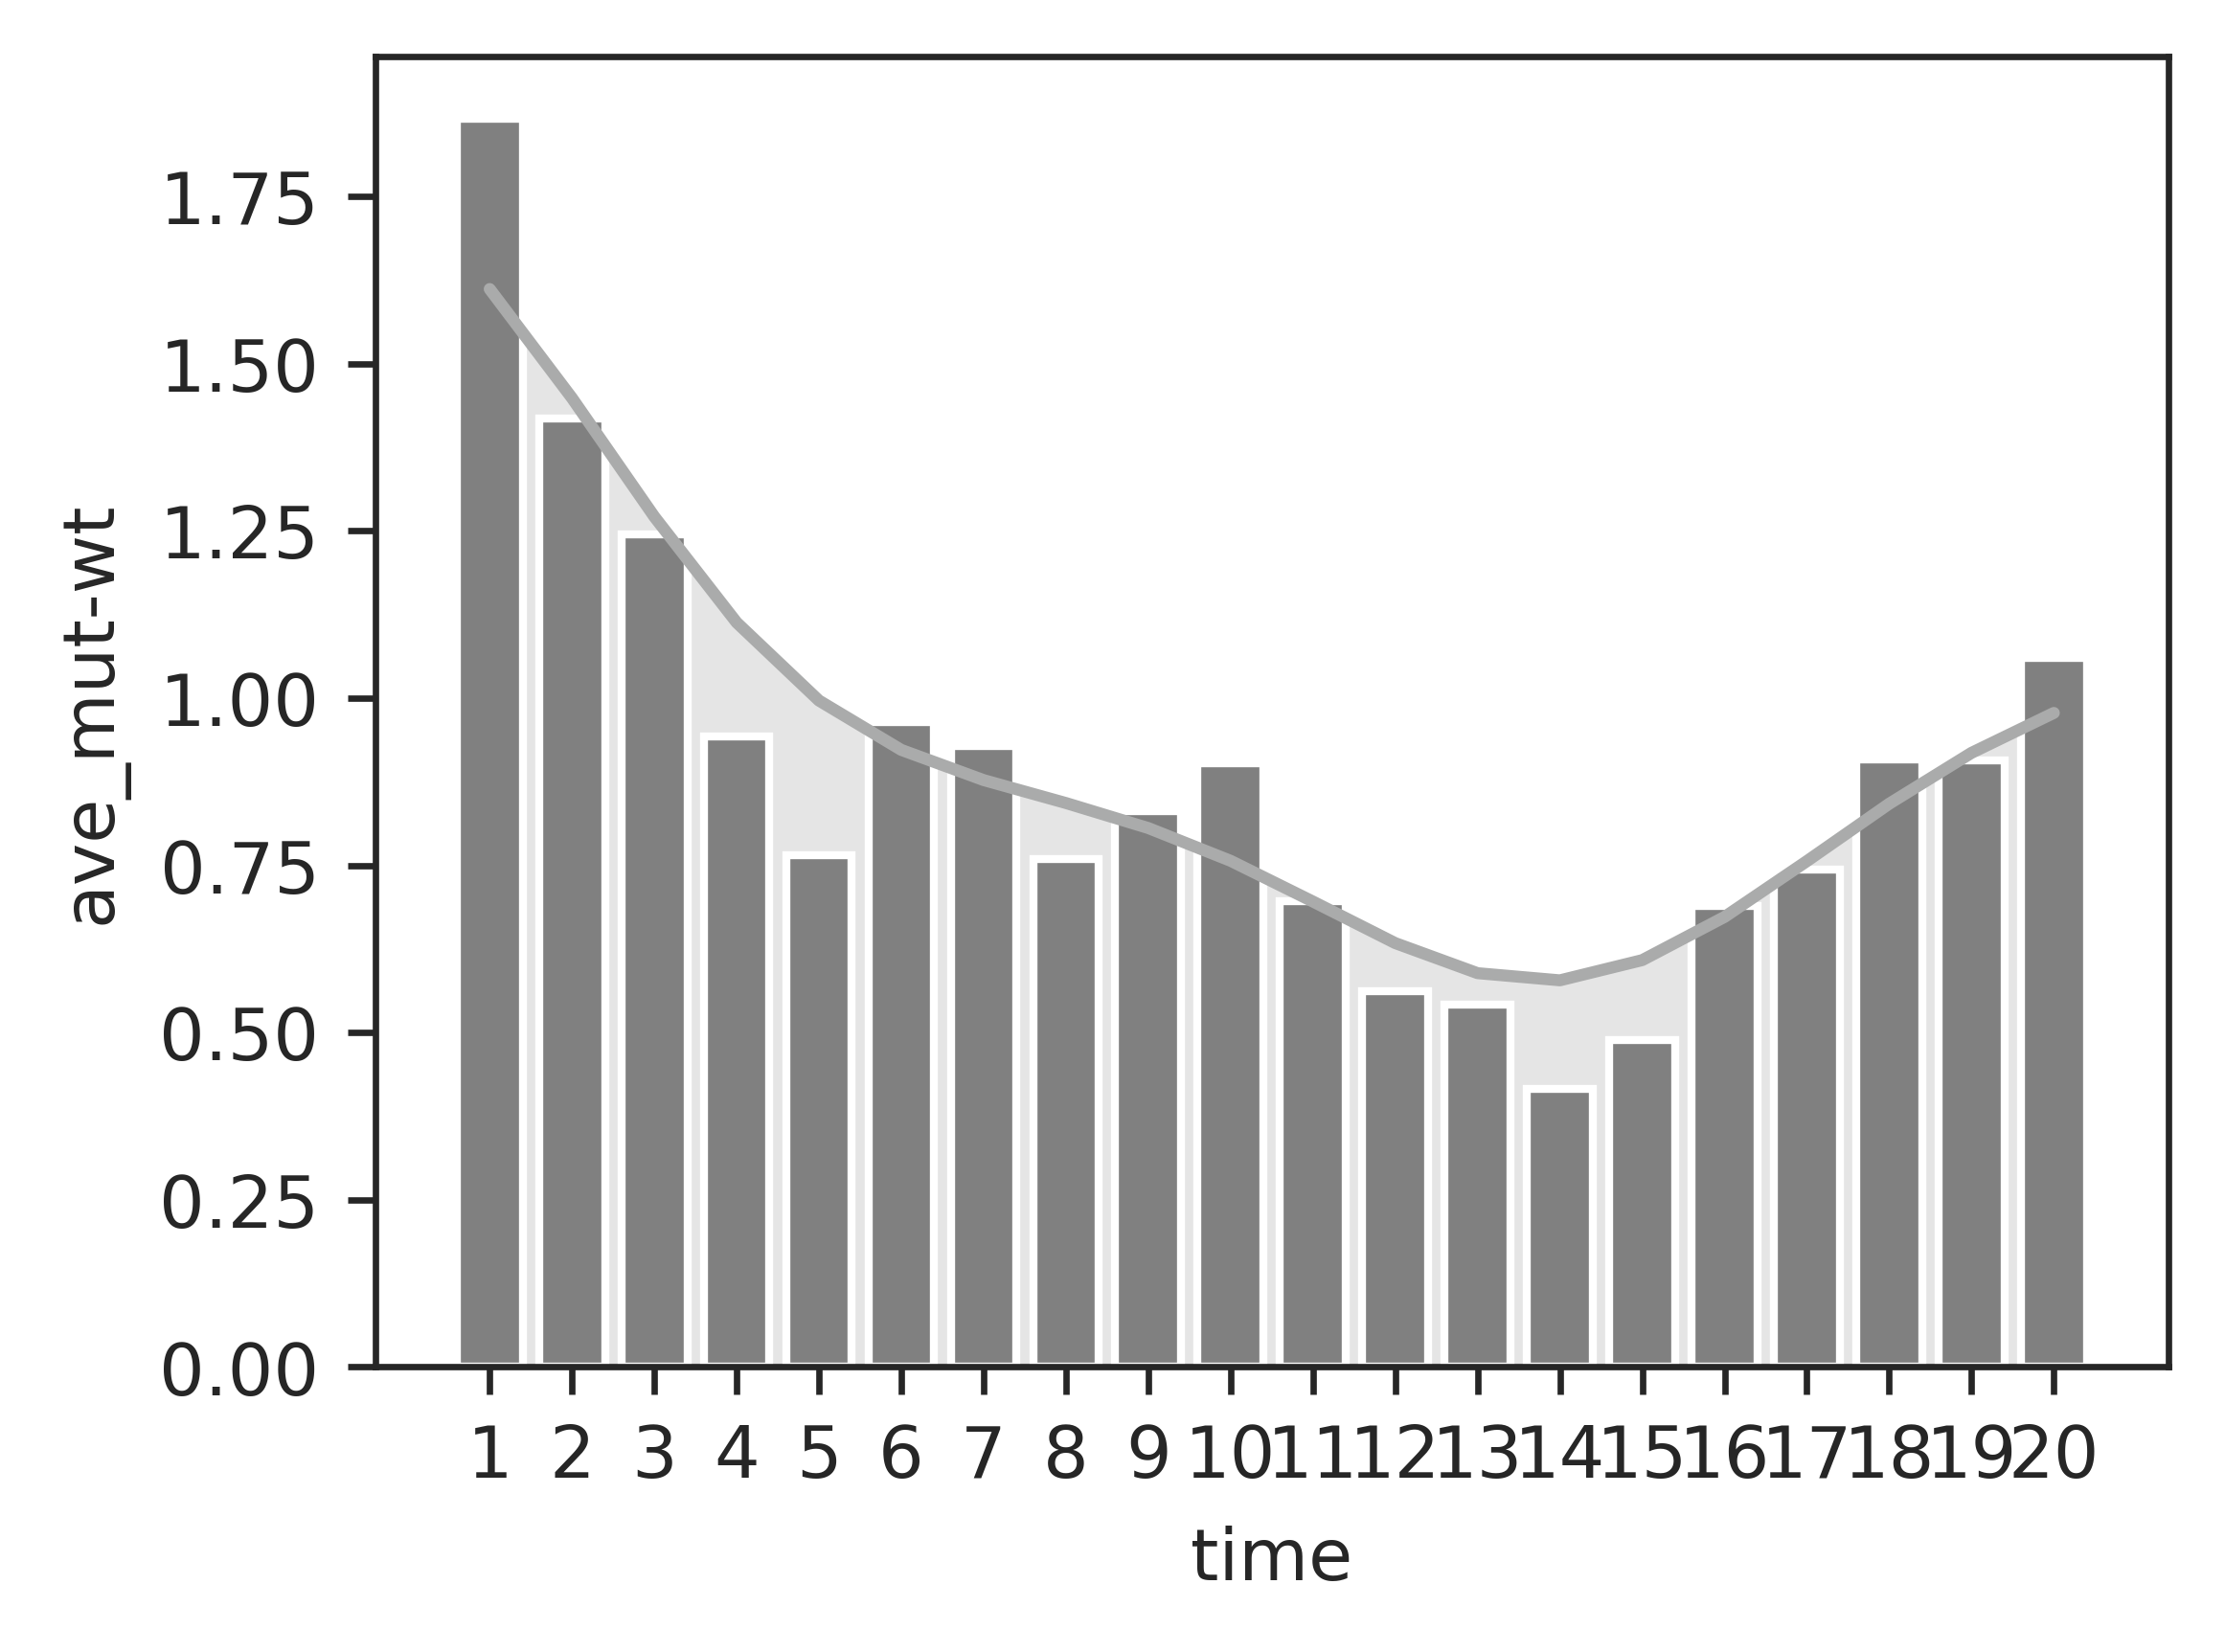

In [27]:
yprime = gaussian_filter1d(
    z['ave_mut-wt'],
    2,
    axis=-1,
    order=0,
    output=None,
    mode='nearest',
    cval=0.0,
    truncate=4.0,
)
fig, ax = plt.subplots(1,1, figsize=(4,3))
sns.barplot(x='time', y='ave_mut-wt', data=z, color='gray', ax=ax)
ax.plot(z['time']-1, yprime, color='#AAABAB')
ax.fill_between(z['time']-1, 0, yprime, color='gray', alpha=0.2)
fig.savefig(os.path.join(pfp, '220902_dyn_ctype_DCN.pdf'), bbox_inches='tight')

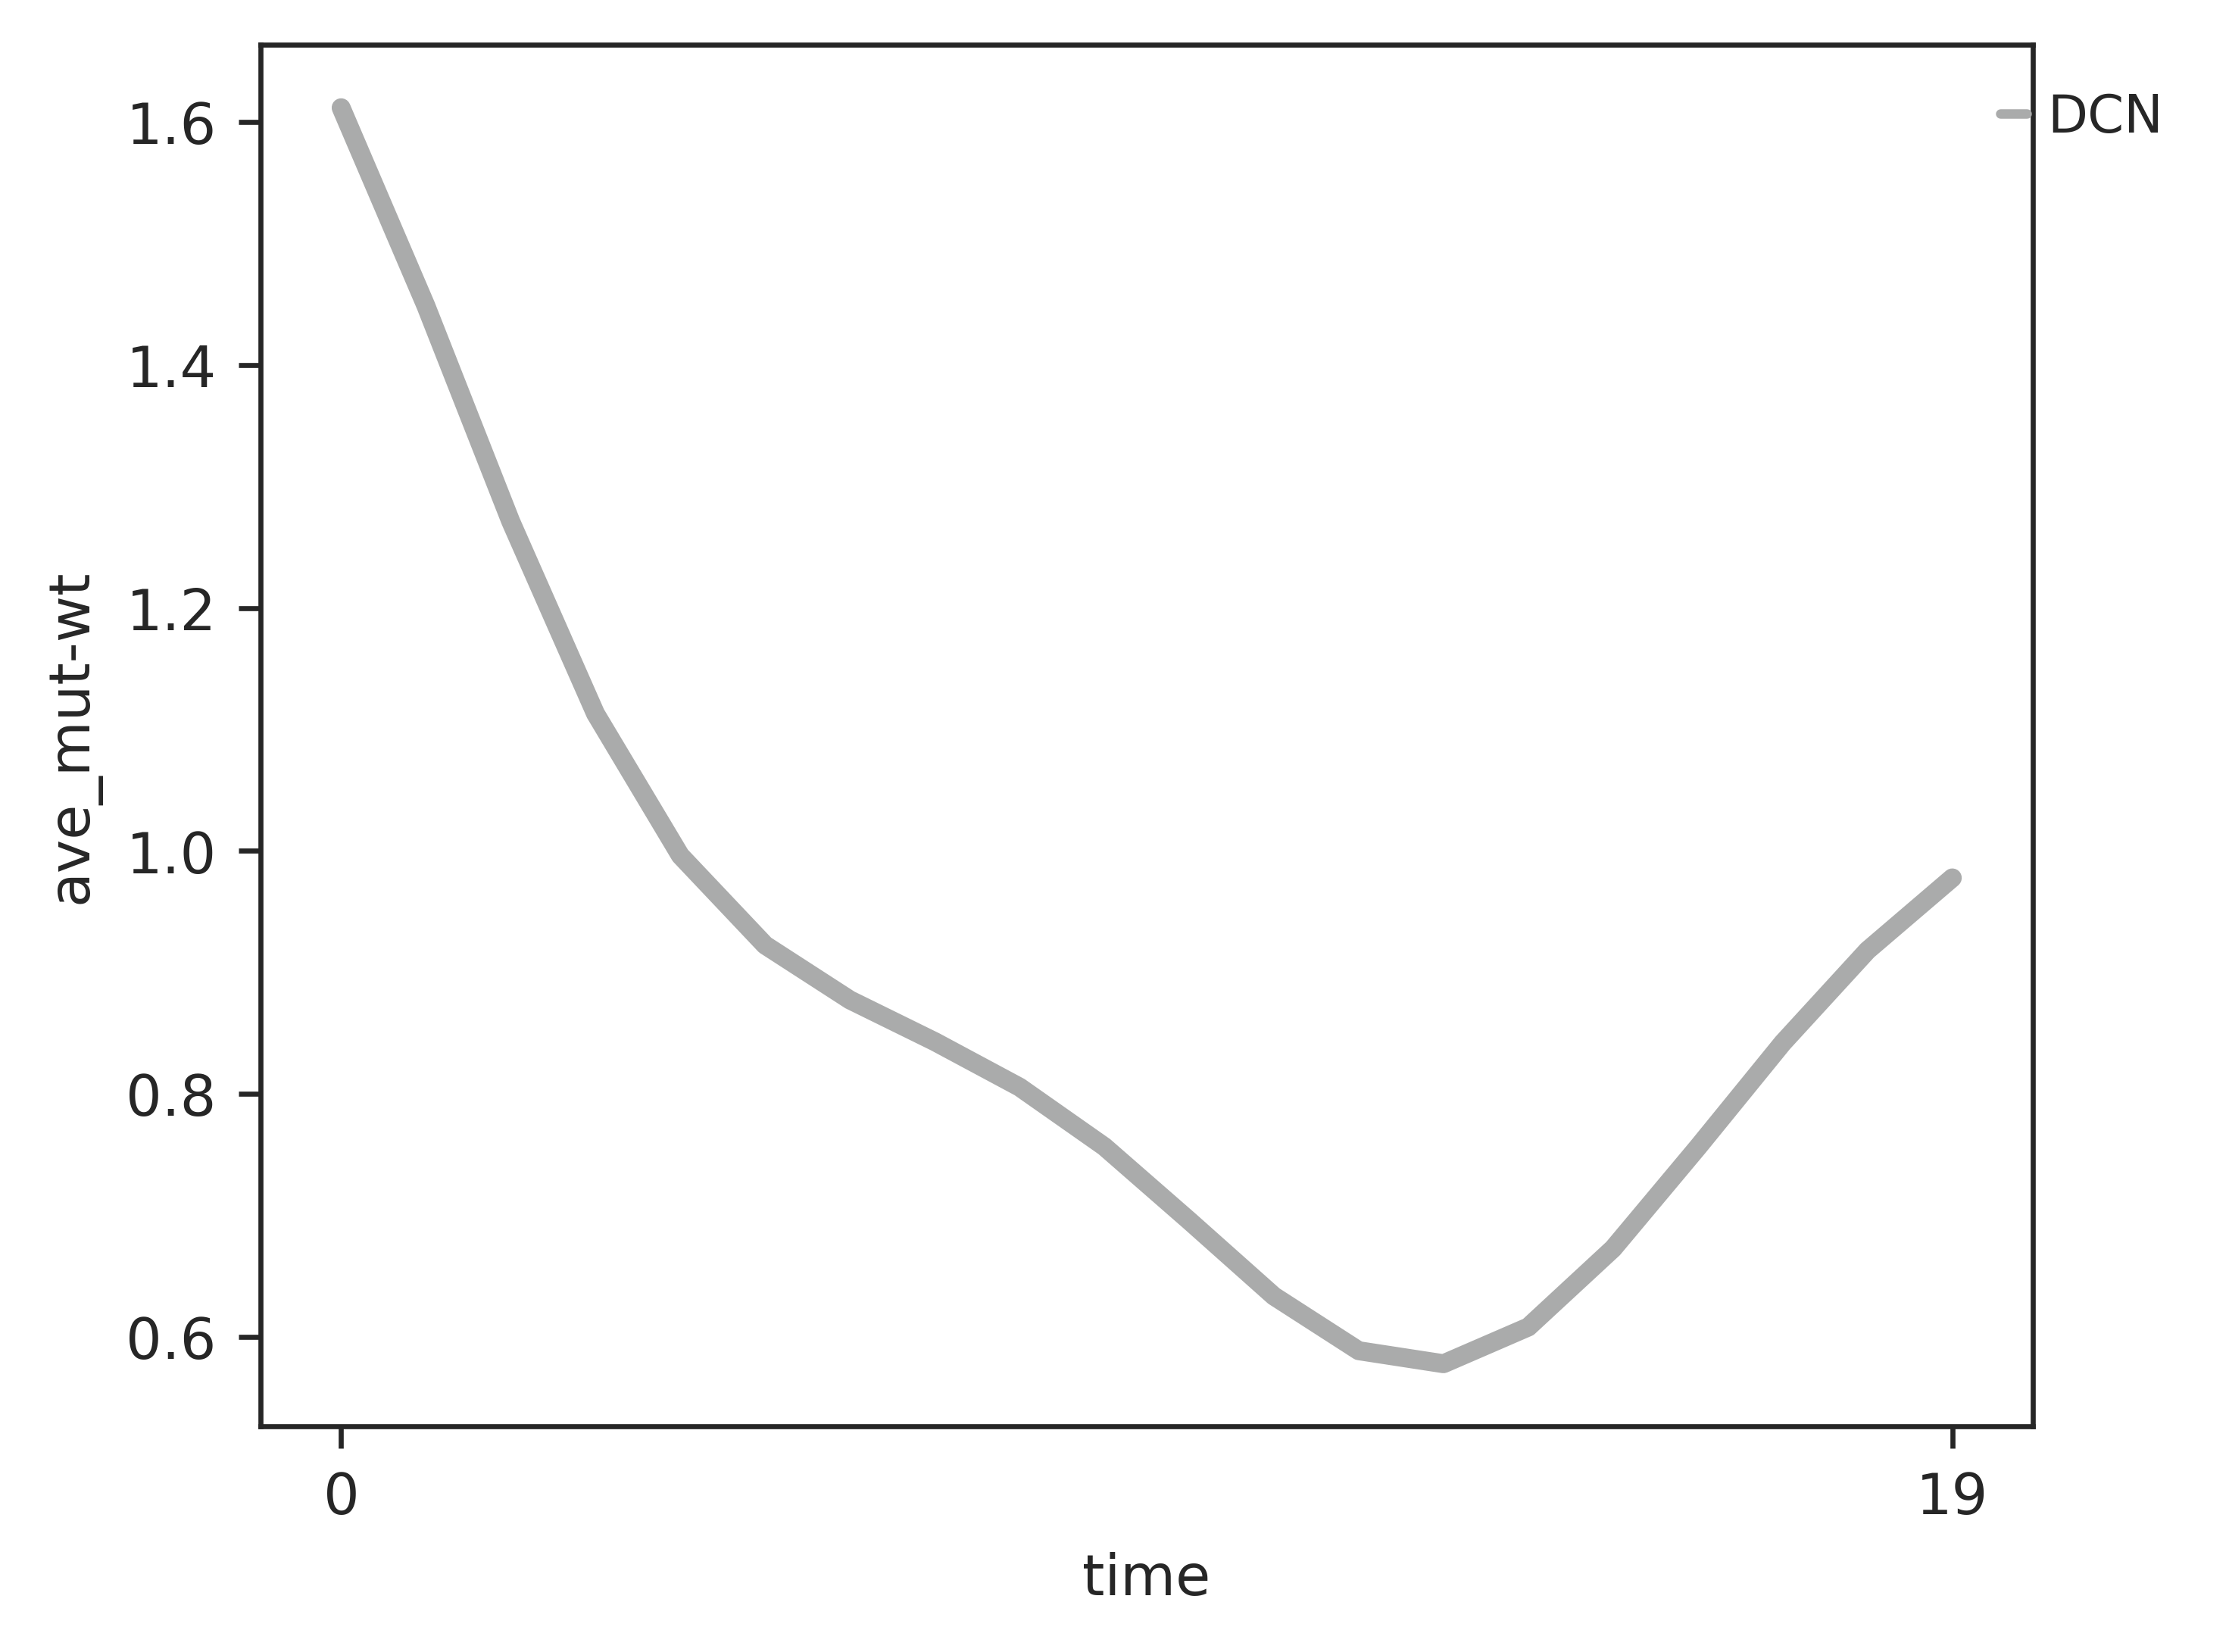

In [82]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
sns.lineplot(x='time', y='ave_mut-wt', hue='ctype', size=None, 
                 style=None, data=dt, palette=cmap_ctype, hue_order=None, 
                 hue_norm=None, sizes=None, size_order=None, size_norm=None, 
                 dashes=True, markers=None, style_order=None, 
                 units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, 
                 err_style='band', err_kws=None, legend='brief', ax=ax, lw=3)
ax.legend(bbox_to_anchor=(1.1,1)).set_title('')
ax.set_xticks([0,19])
#fig.savefig(os.path.join(pfp, '220902_dyn_ctype.pdf'), bbox_inches='tight')